In [1]:
# Importing and setup
import pandas as pd
import matplotlib
import sklearn
import numpy as np
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, word_tokenize, sent_tokenize
import string
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/snawshad26/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/snawshad26/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/snawshad26/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

There are 3150 samples, and 8 features.


'\nThe following interpretations can be drawn from the histograms:\n\n1. From (a), the overwhelming majority of articles (>50%) contain between 0 and 5000 characters, some (~30%) contain between 5000 and 10000 characters\n2. From (b), it can be observed that there is an even split among the data between all 9 leaf labels\n3. From (c), it can be observed that there are exactly 350 more articles with sports as the root label than climate as the root label. This makes sense because there are 5 leaf labels under sports and only 4 leaf labels under climate.\n'

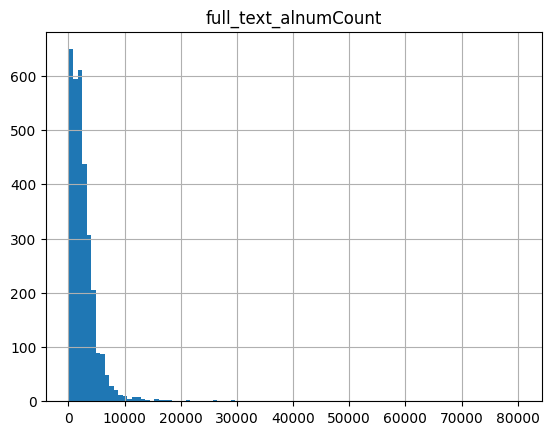

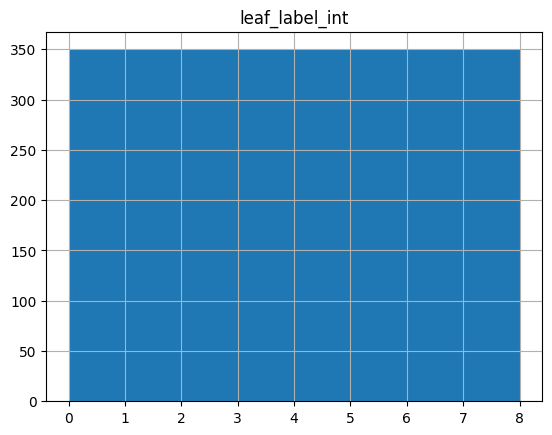

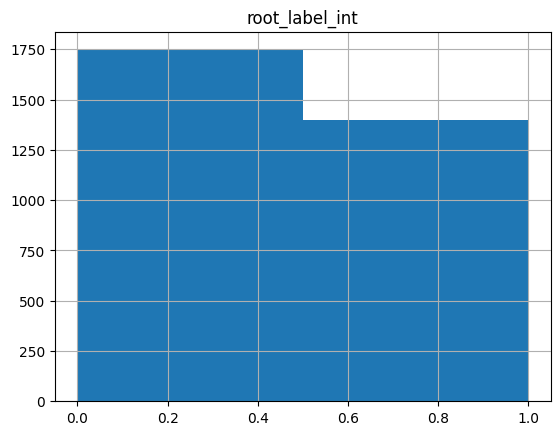

In [2]:
########## Question 1
df = pd.read_csv('Project1-Classification.csv')

########## Overview
print("There are " + str(df.shape[0]) + " samples, and " + str(df.shape[1]) + " features.")

########## Histograms
##### a
# define lambda function to count alpha-numeric characters
count_alpha_numeric = lambda s: sum(c.isalnum() for c in s)

# apply lambda function to each row of full_text
df['full_text_alnumCount'] = df['full_text'].apply(count_alpha_numeric)

# generate histogram
df.hist(column="full_text_alnumCount", bins=100)

##### b
# create a dictionary to map  labels to unique integer values
leaf_label_map = {label: i for i, label in enumerate(df['leaf_label'].unique())}

# create a new column in the DataFrame with the integer values
df['leaf_label_int'] = df['leaf_label'].map(leaf_label_map)

# generate histogram
df.hist(column="leaf_label_int", bins=9)

##### c
# create a dictionary to map  labels to unique integer values
root_label_map = {label: i for i, label in enumerate(df['root_label'].unique())}

# create a new column in the DataFrame with the integer values
df['root_label_int'] = df['root_label'].map(root_label_map)

df.hist(column="root_label_int", bins=2)

########## Interpret Plots
"""
The following interpretations can be drawn from the histograms:

1. From (a), the overwhelming majority of articles (>50%) contain between 0 and 5000 characters, some (~30%) contain between 5000 and 10000 characters
2. From (b), it can be observed that there is an even split among the data between all 9 leaf labels
3. From (c), it can be observed that there are exactly 350 more articles with sports as the root label than climate as the root label. This makes sense because there are 5 leaf labels under sports and only 4 leaf labels under climate.
"""

In [3]:
########## Question 2
import numpy as np
import random
np.random.seed(42)
random.seed(42)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label_int"]], test_size=0.2)


print("There are " + str(train.shape[0]) + " training samples and " + str(test.shape[0]) + " test samples.")

There are 2520 training samples and 630 test samples.


In [4]:
########### Question 3
# Cleaner code:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

def penn2morphy(penntag): 
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatized(text):
    lemmatizer = WordNetLemmatizer()

    sent_pos_tags = [pos_tag(word_tokenize(sent)) for sent in sent_tokenize(text)]
    pos_tags = []
    for sentence_tags in sent_pos_tags:
        for tags in sentence_tags:
            pos_tags.append(tags)
    
    lemmatized_words = []
    lemm_text = [lemmatizer.lemmatize(word, pos = penn2morphy(tag)) for word, tag in pos_tags]
    for lemma in lemm_text:
        if (not any(char in lemma for char in string.punctuation)):
            lemmatized_words.append(lemma.lower())
    return ' '.join(lemmatized_words)

def preprocess(text):
  return lemmatized(clean(text))
  

# processing data by using provided cleaner code
train["cleaned"] = train['full_text'].apply(lambda x:preprocess(x))
test["cleaned"] = test['full_text'].apply(lambda x:preprocess(x))

# Using english stopwords of the CountVectorizer and excluding terms that are numbers with the token pattern argument
from sklearn.feature_extraction.text import CountVectorizer
tfidf_transformer = TfidfTransformer(use_idf=True)
pattern = r'\b[A-Za-z]+\b'
vectorizer = CountVectorizer(stop_words='english',token_pattern = pattern, min_df=3)

# Creating vector representations from the CountVectorizer created of the processed training and test data
Xtrain_vec = vectorizer.fit_transform(train['cleaned'])
Xtrain_tf = tfidf_transformer.fit_transform(Xtrain_vec)
Xtrain_array_tf = Xtrain_tf.toarray()
Xtrain = pd.DataFrame(data = Xtrain_array_tf, columns = vectorizer.get_feature_names_out())

Xtest_vec = vectorizer.transform(test['cleaned'])
Xtest_tf = tfidf_transformer.transform(Xtest_vec)
Xtest_array_tf = Xtest_tf.toarray()
Xtest = pd.DataFrame(data = Xtest_array_tf, columns = vectorizer.get_feature_names_out())

ytrain_true = train['root_label_int'].values
ytest_true = test['root_label_int'].values

print('TF-IDF Processed train matrix shape:', Xtrain.shape)
print('TF-IDF Processed test matrix shape:', Xtest.shape)


TF-IDF Processed train matrix shape: (2520, 14084)
TF-IDF Processed test matrix shape: (630, 14084)


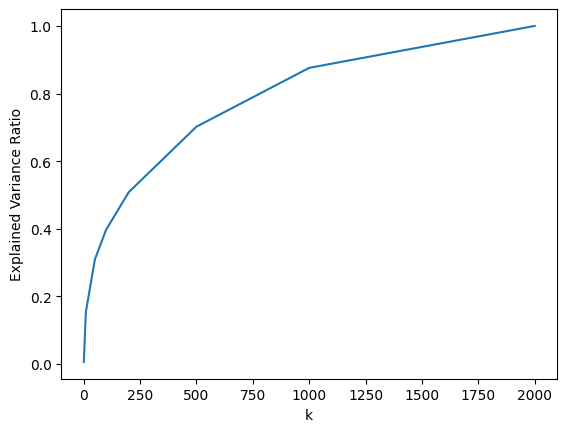

In [5]:
########## Question 4
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF

k = [1, 10, 50, 100, 200, 500, 1000, 2000]
explained_variance_ratio = []

for i in range(len(k)):
    svd_t = TruncatedSVD(n_components=k[i], random_state=42)
    svd_t.fit(Xtrain)
    explained_variance_ratio.append(sum(svd_t.explained_variance_ratio_))

plt.plot(k, explained_variance_ratio);
plt.ylabel("Explained Variance Ratio")
plt.xlabel("k")
plt.show()

In [6]:
k = 50
svd = TruncatedSVD(n_components = k)
#Fit the model on training data and then perform dimensionality reduction
Xtrain_lsi = svd.fit_transform(Xtrain)
Xtest_lsi = svd.transform(Xtest)

print('Dimensionality Reduction: '+str(Xtrain.shape[1])+' features was reduced to '+str(Xtrain_lsi.shape[1]))

Dimensionality Reduction: 14084 features was reduced to 50


In [7]:
u, s, vh = np.linalg.svd(Xtrain)
sd = np.diag(s)
vht = np.transpose(vh)

k = 50
LSI_FN = np.sum(np.square(np.array(Xtrain - u[:,:k] @ sd[0:k,0:k] @ vh[:k,:])))
SIGMA_V = svd.components_
LSI_err = np.sum(np.square(np.array(Xtrain - (Xtrain_lsi @SIGMA_V))))

#LSI_MSE = MSE(word_counts_train, (u[:,:k] @ sd[0:k,0:k] @ vh[:k,:]))
print("LSI Frobenius Norm:",LSI_FN)

model = NMF(n_components=50, init='random', random_state=42)
W = model.fit_transform(Xtrain)
H = model.components_

NMF_FN = np.sum(np.square(np.array(Xtrain - (W @ H))))
#NMF_MSE = MSE(word_counts_train, (W @ H))
print("NMF Frobenius Norm:",NMF_FN)
#We need value in 4000

if LSI_FN > NMF_FN:
    print('Loss of LSI is larger')
elif LSI_FN < NMF_FN:
    print('Loss of NMF is larger')

LSI Frobenius Norm: 1683.6670208184883


/opt/homebrew/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF Frobenius Norm: 1711.2402419439723
Loss of NMF is larger


SVM with gamma=1000 (hard margin):
Confusion matrix:



/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


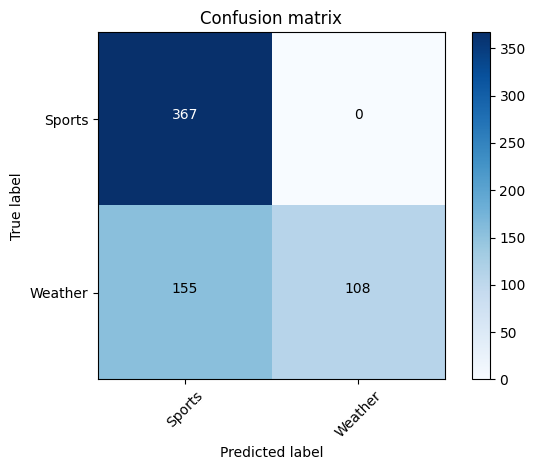

Accuracy: 0.753968253968254
Precision: 0.8515325670498084
Recall: 0.7053231939163498
F1 score: 0.7039285183691661

SVM with gamma=0.0001 (soft margin):
Confusion matrix:



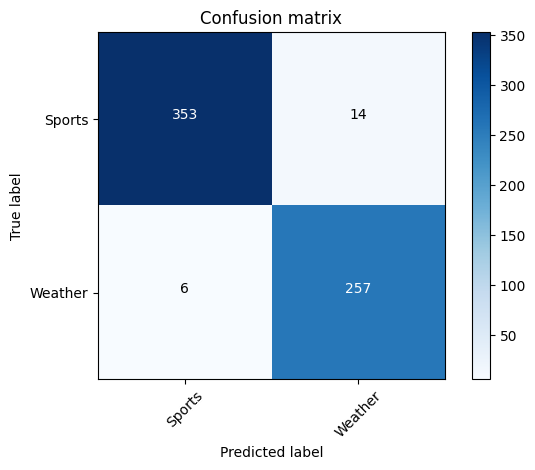

Accuracy: 0.9682539682539683
Precision: 0.9658131957364142
Recall: 0.9695195864112474
F1 score: 0.9674993035565048


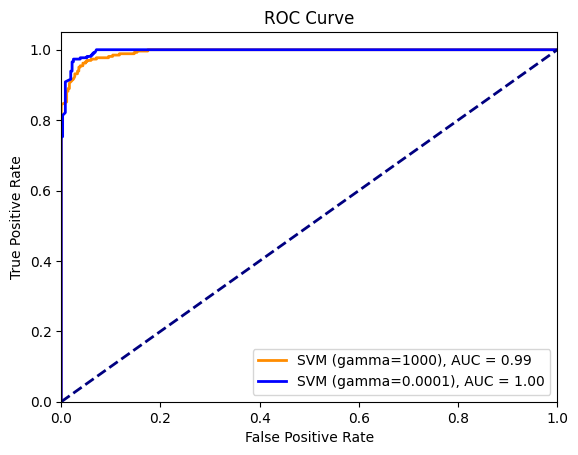

In [8]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

########## Question 5


# Train linear SVM with gamma=1000 (hard margin)
svm_hard = LinearSVC(C=1/1000, max_iter=10000)
svm_hard.fit(Xtrain, ytrain_true)

# Train linear SVM with gamma=0.0001 (soft margin)
svm_soft = LinearSVC(C=1/0.0001, max_iter=10000)
svm_soft.fit(Xtrain, ytrain_true)

# Predict class labels of test data using the two SVMs
y_pred_hard = svm_hard.predict(Xtest)
y_pred_soft = svm_soft.predict(Xtest)

# Evaluate performance of the two SVMs
print("SVM with gamma=1000 (hard margin):")
print("Confusion matrix:\n")
plt.figure()
plot_confusion_matrix(confusion_matrix(ytest_true, y_pred_hard), classes = ['Sports', 'Weather'])
plt.show()
print("Accuracy:", accuracy_score(ytest_true, y_pred_hard))
print("Precision:", precision_score(ytest_true, y_pred_hard, average='macro'))
print("Recall:", recall_score(ytest_true, y_pred_hard, average='macro'))
print("F1 score:", f1_score(ytest_true, y_pred_hard, average='macro'))

print("\nSVM with gamma=0.0001 (soft margin):")
print("Confusion matrix:\n") 
plt.figure()
plot_confusion_matrix(confusion_matrix(ytest_true, y_pred_soft), classes = ['Sports', 'Weather'])
plt.show()
print("Accuracy:", accuracy_score(ytest_true, y_pred_soft))
print("Precision:", precision_score(ytest_true, y_pred_soft, average='macro'))
print("Recall:", recall_score(ytest_true, y_pred_soft, average='macro'))
print("F1 score:", f1_score(ytest_true, y_pred_soft, average='macro'))

# Plot ROC curve for both SVMs
fpr_hard, tpr_hard, _ = roc_curve(ytest_true, svm_hard.decision_function(Xtest))
fpr_soft, tpr_soft, _ = roc_curve(ytest_true, svm_soft.decision_function(Xtest))
roc_auc_hard = auc(fpr_hard, tpr_hard)
roc_auc_soft = auc(fpr_soft, tpr_soft)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_hard, tpr_hard, color='darkorange', lw=2, label='SVM (gamma=1000), AUC = %0.2f' % roc_auc_hard)
plt.plot(fpr_soft, tpr_soft, color='blue', lw=2, label='SVM (gamma=0.0001), AUC = %0.2f' % roc_auc_soft)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Accuracy score for Logistic Regression without regularization: 0.958730
Recall score for Logistic Regression without regularization: 0.977186
Precision score for Logistic Regression without regularization: 0.927798
F-1 score for Logistic Regression without regularization: 0.951852


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


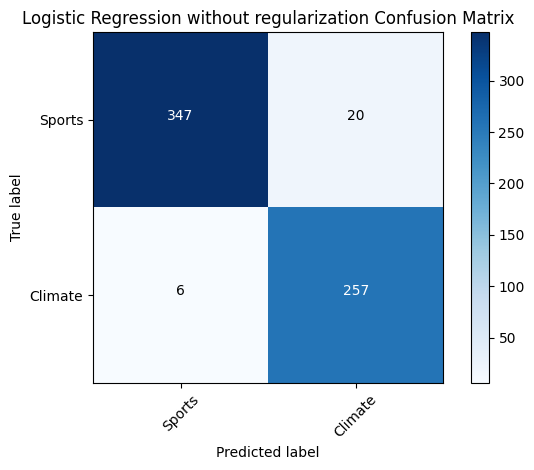

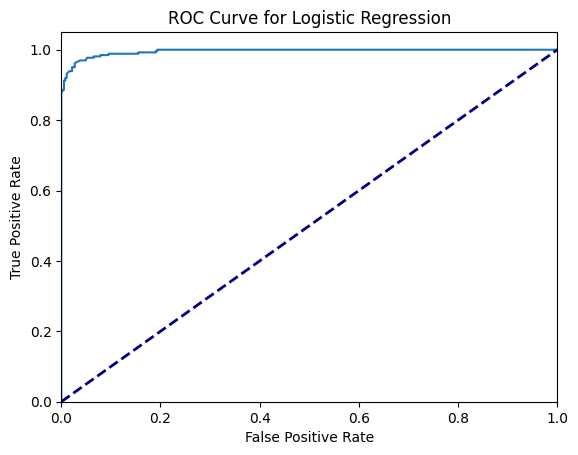

In [9]:
########## Question 6
def Classifier_Metrics(y_test,y_pred,name="",average='binary'):
    print("Accuracy score for %s: %f" %(name,accuracy_score(y_test,y_pred)))
    print("Recall score for %s: %f" % (name,recall_score(y_test,y_pred,average=average)))
    print("Precision score for %s: %f" % (name,precision_score(y_test,y_pred,average=average)))
    print("F-1 score for %s: %f" % (name,f1_score(y_test,y_pred,average=average)))
class_names = ["Sports","Climate"]
LR = LogisticRegression(penalty = 'none', random_state = 42)
pred_lr = LR.fit(Xtrain_lsi,ytrain_true).predict(Xtest_lsi)

Classifier_Metrics(ytest_true, pred_lr, name="Logistic Regression without regularization")
Logistics_Regression_cm = confusion_matrix(ytest_true,pred_lr)
plt.figure(); plot_confusion_matrix(Logistics_Regression_cm, classes=class_names, title='Logistic Regression without regularization Confusion Matrix') 

fpr_lr, tpr_lr, _ = roc_curve(ytest_true,LR.decision_function(Xtest_lsi))
plt.figure()
plt.plot(fpr_lr,tpr_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.show()
